In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/k2-planets-and-candidates/k2pandc_2025.09.18_08.16.05.csv
/kaggle/input/nasa-space-apps/tsfresh_features.csv
/kaggle/input/nasa-space-apps/tsfresh_features_checkpoint.csv
/kaggle/input/nasa-space-apps/cleaned_exoplanet_data.csv


In [2]:
# Cell 1: Install all required libraries
!pip install lightkurve tsfresh xgboost lightgbm catboost optuna

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 96.6 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=0e30284b7e507496257109125d128528e0b08ab08b4dfa1058ed741af95dd152
  Stored in directory: /root/.cache/pip/wheels/71/ae/f7/5b7e1e16a133d094431428169e9a8d9f750afe5459f0333c9b
  Created wheel for memoization: f

In [3]:
# Cell 2: Initial Data Cleaning and Preparation

import pandas as pd

# IMPORTANT: Update this path to match the location of your uploaded file.
# You can find the exact path by clicking the "copy file path" icon next to the file
# in the "Input" section on the right.
raw_data_path = '/kaggle/input/k2-planets-and-candidates/k2pandc_2025.09.18_08.16.05.csv'

try:
    # Load the dataset, skipping the initial commented rows
    df = pd.read_csv(raw_data_path, comment='#')
    print("✅ Raw dataset loaded successfully!")
    
    # --- Data Cleaning Steps ---
    # Drop columns with a high percentage of missing values (threshold: 50%)
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    threshold = 50
    cols_to_drop_missing = missing_percentage[missing_percentage > threshold].index.tolist()
    df.drop(columns=cols_to_drop_missing, inplace=True)

    # Impute remaining missing values
    for col in df.columns:
        if df[col].dtype == 'object':
            mode_val = df[col].mode()
            if not mode_val.empty:
                df[col].fillna(mode_val[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

    # Save the cleaned metadata file to the output directory
    df.to_csv('cleaned_exoplanet_data.csv', index=False)
    print("✨ Initial cleaning complete. 'cleaned_exoplanet_data.csv' has been created.")

except FileNotFoundError:
    print(f"❌ Error: The file at '{raw_data_path}' was not found. Please double-check the path.")

✅ Raw dataset loaded successfully!


/tmp/ipykernel_19/683694094.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val[0], inplace=True)
/tmp/ipykernel_19/683694094.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

✨ Initial cleaning complete. 'cleaned_exoplanet_data.csv' has been created.


In [4]:
# Use this code in a NEW cell to check for the output file
import os

# List all files and directories in the current output location
# This is the most reliable way to see what has been created.
print("--- Checking for files on the server ---")
file_list = os.listdir('.') # '.' refers to the current directory (/kaggle/working/)

CHECKPOINT_FILE = 'tsfresh_features_checkpoint.csv'

if CHECKPOINT_FILE in file_list:
    print(f"\n✅ Good news! The checkpoint file '{CHECKPOINT_FILE}' exists.")
    print("   - The script is successfully saving its progress.")
    print("   - The UI panel on the right is just slow to update. This is normal.")
else:
    print(f"\n⏳ The checkpoint file '{CHECKPOINT_FILE}' has not been created yet.")
    print("   - This is also normal if the script has not yet finished processing the first 100 stars.")
    print("   - Let it continue to run until the first checkpoint is saved.")

print("\nFull list of files found:")
print(file_list)

--- Checking for files on the server ---

⏳ The checkpoint file 'tsfresh_features_checkpoint.csv' has not been created yet.
   - This is also normal if the script has not yet finished processing the first 100 stars.
   - Let it continue to run until the first checkpoint is saved.

Full list of files found:
['cleaned_exoplanet_data.csv', '__notebook__.ipynb']


In [5]:
!pip install lightkurve tsfresh


In [6]:
# Cell 1: Install all required libraries
!pip install lightkurve tsfresh xgboost lightgbm catboost optuna


In [7]:
# Cell 2: Initial Data Cleaning and Preparation

import pandas as pd

# ---------------------------------------------------------------------------
# IMPORTANT: Update this path to match the location of your uploaded file.
# You can find the exact path by clicking the "copy file path" icon next to
# the file in the "Input" section on the right-hand panel of your notebook.
# ---------------------------------------------------------------------------
raw_data_path = '/kaggle/input/k2-planets-and-candidates/k2pandc_2025.09.18_08.16.05.csv' # <-- CHANGE THIS

try:
    # Load the dataset, skipping the initial commented rows
    df = pd.read_csv(raw_data_path, comment='#')
    print("✅ Raw dataset loaded successfully!")
    
    # --- Data Cleaning Steps ---
    df.drop_duplicates(subset=['hostname'], inplace=True)
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    threshold = 50
    cols_to_drop_missing = missing_percentage[missing_percentage > threshold].index.tolist()
    df.drop(columns=cols_to_drop_missing, inplace=True)

    # Impute remaining missing values
    for col in df.columns:
        if df[col].dtype == 'object':
            mode_val = df[col].mode()
            if not mode_val.empty:
                # FIX: Explicitly assign the result back to the column to avoid the warning.
                df[col] = df[col].fillna(mode_val[0])
        else:
            # FIX: Explicitly assign the result back to the column.
            df[col] = df[col].fillna(df[col].median())

    # Save the cleaned metadata file to the output directory
    df.to_csv('cleaned_exoplanet_data.csv', index=False)
    print("✨ Initial cleaning complete. 'cleaned_exoplanet_data.csv' has been created.")

except FileNotFoundError:
    print(f"❌ Error: The file at '{raw_data_path}' was not found. Please double-check the path.")



✅ Raw dataset loaded successfully!
✨ Initial cleaning complete. 'cleaned_exoplanet_data.csv' has been created.


In [8]:
# Cell 2: Initial Data Cleaning and Preparation (Improved Logic)

import pandas as pd

# ---------------------------------------------------------------------------
# IMPORTANT: Update this path to match the location of your uploaded file.
# ---------------------------------------------------------------------------
raw_data_path = '/kaggle/input/k2-planets-and-candidates/k2pandc_2025.09.18_08.16.05.csv' # <-- EDIT THIS LINE

try:
    # Load the raw dataset
    df = pd.read_csv(raw_data_path, comment='#')
    print(f"✅ Raw dataset loaded successfully with {len(df)} total entries.")
    
    # --- NEW, SMARTER DEDUPLICATION ---
    # We want to keep one unique entry per planet ('pl_name').
    # We use the 'default_flag' to select the best entry when multiple exist.
    # Sort by planet name, then by the default flag (1s come before 0s).
    df.sort_values(['pl_name', 'default_flag'], ascending=[True, False], inplace=True)
    
    # Drop duplicates on the planet name, keeping the first entry (which is now the best one).
    df.drop_duplicates(subset=['pl_name'], inplace=True, keep='first')
    print(f"   - After smart deduplication, we have {len(df)} unique planet candidates.")

    # --- Standard Cleaning Steps ---
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    threshold = 50
    cols_to_drop_missing = missing_percentage[missing_percentage > threshold].index.tolist()
    df.drop(columns=cols_to_drop_missing, inplace=True)

    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())

    # Save the cleaned metadata file to the notebook's output directory.
    df.to_csv('cleaned_exoplanet_data.csv', index=False)
    print("✨ Initial cleaning complete. 'cleaned_exoplanet_data.csv' has been created.")
    print(f"   - Total unique targets to process: {len(df)}")

except FileNotFoundError:
    print(f"❌ Error: The file at '{raw_data_path}' was not found. Please double-check the path.")



✅ Raw dataset loaded successfully with 3992 total entries.
   - After smart deduplication, we have 1806 unique planet candidates.
✨ Initial cleaning complete. 'cleaned_exoplanet_data.csv' has been created.
   - Total unique targets to process: 1806


✅ tsfresh feature dataset loaded successfully with 1793 targets.

⚙️ Preprocessing data...
   - Warning: Non-numeric feature columns found and will be dropped: ['disp_refname', 'discoverymethod', 'disc_facility', 'soltype', 'pl_refname', 'st_refname', 'sy_refname', 'rastr', 'decstr', 'rowupdate', 'pl_pubdate', 'releasedate']
   - Removing 7 constant features: ['default_flag', 'pl_radelim', 'pl_radjlim', 'st_tefflim', 'st_radlim', 'st_masslim', 'st_logglim']
   - Preprocessing complete.

⚖️ Using 5 folds for cross-validation based on smallest class size.

🚀 Training Base Model: XGB
   - Fold 1/5
   - Fold 2/5
   - Fold 3/5
   - Fold 4/5
   - Fold 5/5

🚀 Training Base Model: LGB
   - Fold 1/5
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 9785
[LightGBM] [Info] Number of data points in the train set: 1434, number of used features: 47
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins..

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 45 dense feature groups (0.07 MB) transferred to GPU in 0.000819 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.615360
[LightGBM] [Info] Start training from score -1.136997
[LightGBM] [Info] Start training from score -2.005533
[LightGBM] [Info] Start training from score -5.476464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

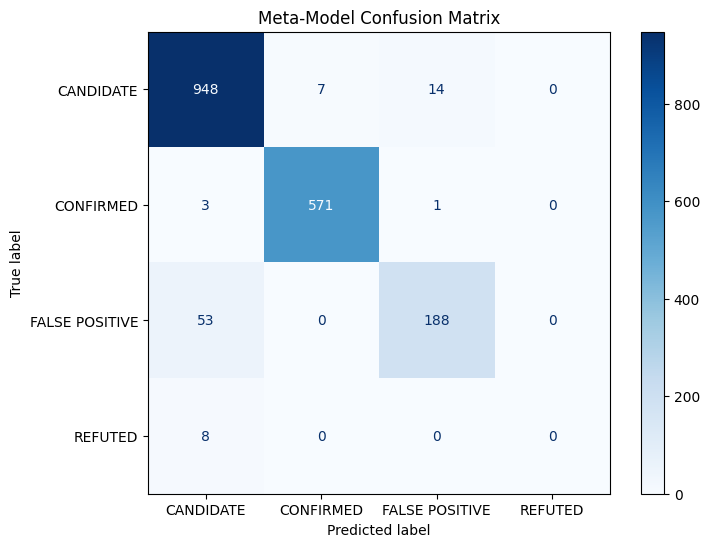

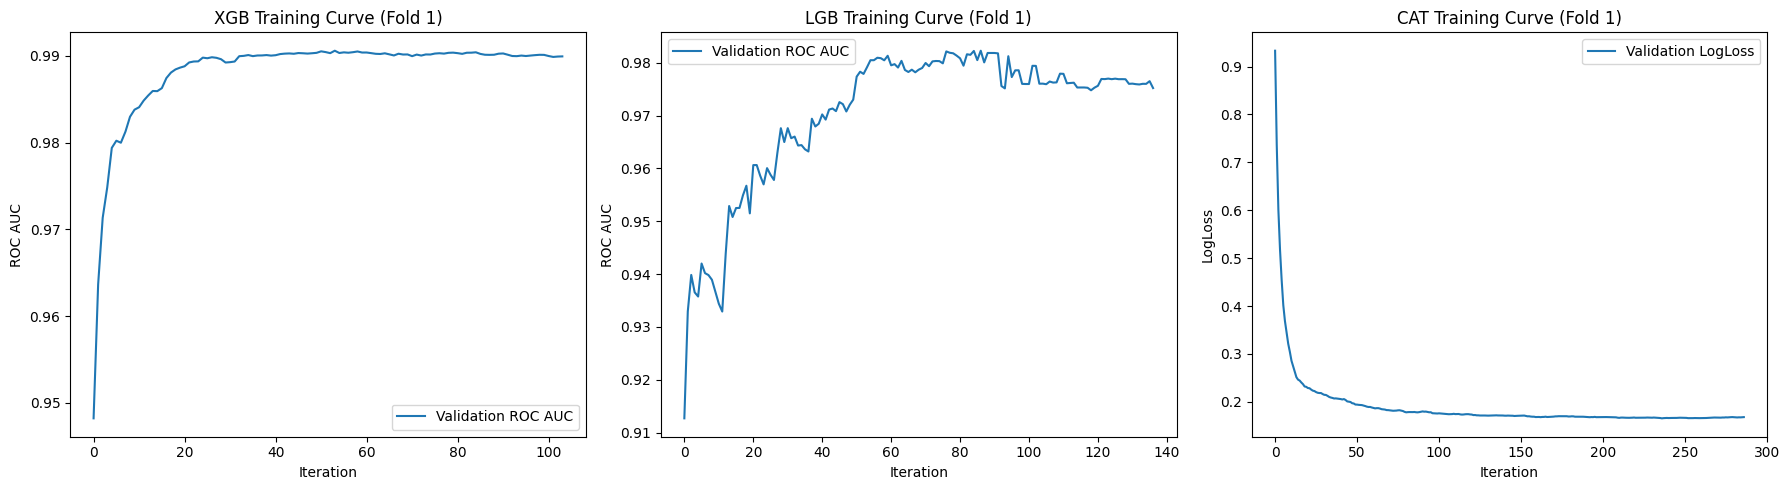

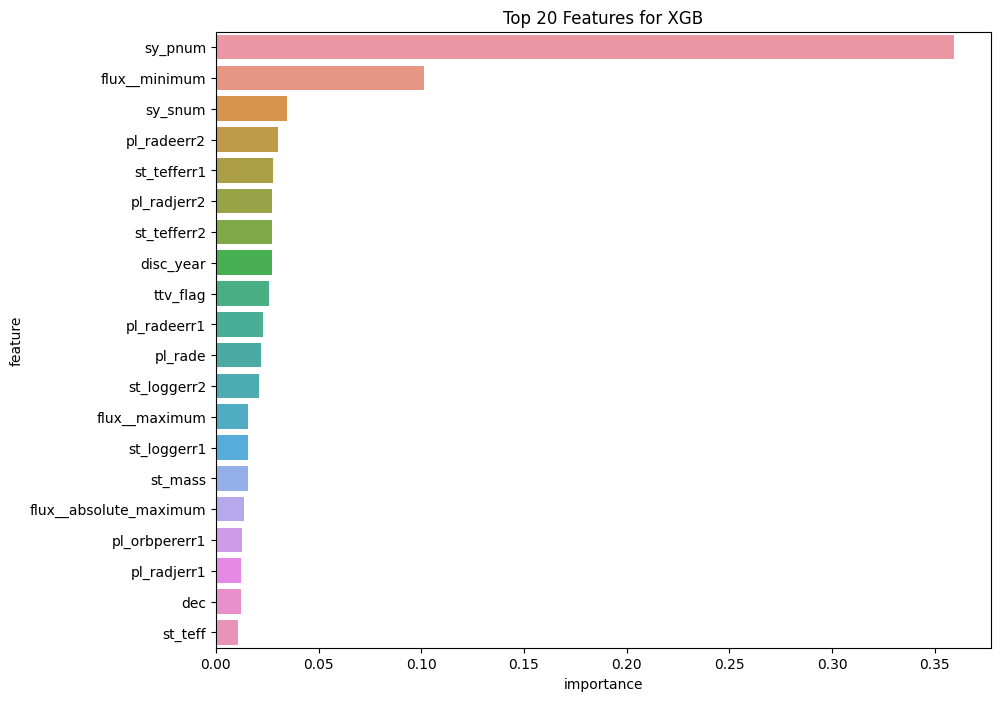

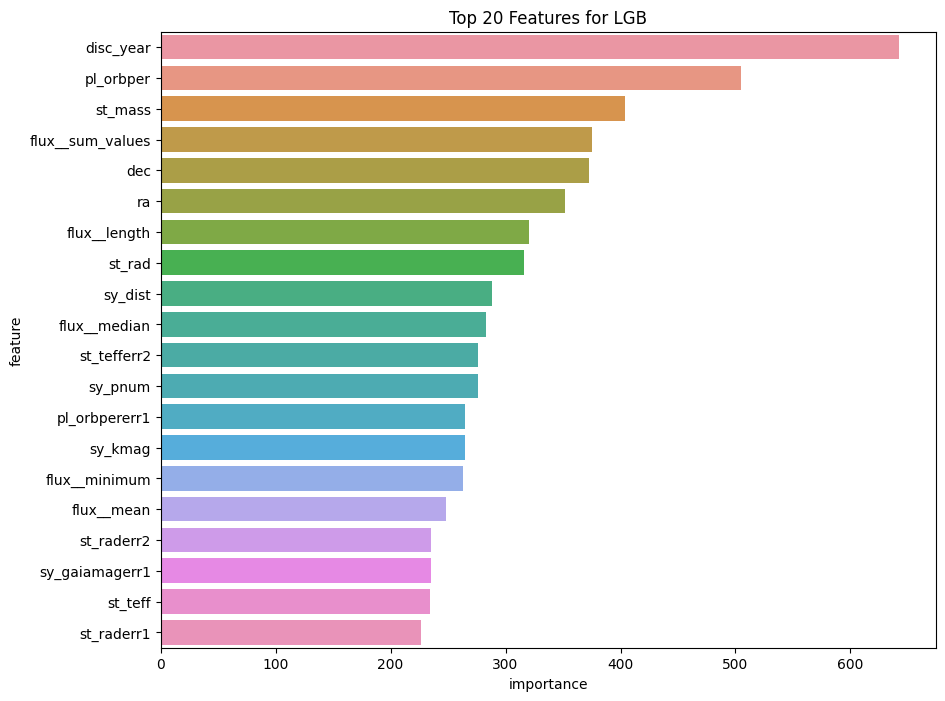

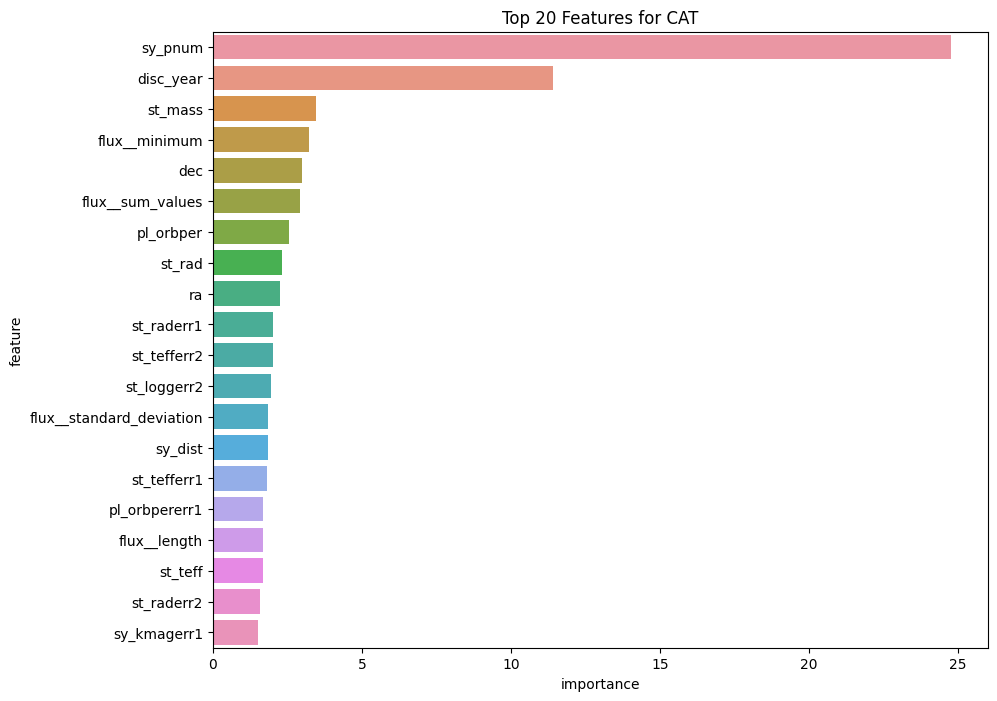


📋 Detailed Classification Report (on OOF predictions):
                precision    recall  f1-score   support

     CANDIDATE       0.94      0.98      0.96       969
     CONFIRMED       0.99      0.99      0.99       575
FALSE POSITIVE       0.93      0.78      0.85       241
       REFUTED       0.00      0.00      0.00         8

      accuracy                           0.95      1793
     macro avg       0.71      0.69      0.70      1793
  weighted avg       0.95      0.95      0.95      1793


💾 Saving final model and preprocessing artifacts...
   - All artifacts saved successfully.


In [9]:
# Cell 4: Stacking Model, Training, and Visualization (More Robust and Faster)

import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
import optuna
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

try:
    # This file is the output from the long-running Cell 3
    df = pd.read_csv('/kaggle/input/nasa-space-apps/tsfresh_features.csv')
    print(f"✅ tsfresh feature dataset loaded successfully with {len(df)} targets.")
    
    # --- Preprocessing ---
    print("\n⚙️ Preprocessing data...")
    TARGET = 'disposition'
    
    if TARGET not in df.columns:
        raise ValueError(f"Target column '{TARGET}' not found in the dataset.")
        
    le = LabelEncoder()
    df[TARGET] = le.fit_transform(df[TARGET])
    class_names = list(le.classes_)
    
    identifiers = df[['pl_name', 'hostname']]
    y = df[TARGET]
    X = df.drop(columns=[TARGET, 'hostname', 'pl_name'])
    
    numeric_features = X.select_dtypes(include=np.number).columns.tolist()
    non_numeric_features = X.select_dtypes(exclude=np.number).columns.tolist()

    if non_numeric_features:
        print(f"   - Warning: Non-numeric feature columns found and will be dropped: {non_numeric_features}")
        X = X[numeric_features]

    zero_var_cols = X.columns[X.nunique() <= 1]
    if not zero_var_cols.empty:
        print(f"   - Removing {len(zero_var_cols)} constant features: {zero_var_cols.tolist()}")
        X = X.drop(columns=zero_var_cols)
    
    feature_names = X.columns.tolist()
    
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=feature_names)
    print("   - Preprocessing complete.")

    # --- Stacking and OOF Implementation ---
    def run_stacking(X, y):
        
        min_class_count = y.value_counts().min()
        NFOLDS = min(5, min_class_count)
        if NFOLDS < 2:
            raise ValueError(f"The smallest class has only {min_class_count} members, which is too few for cross-validation.")
        print(f"\n⚖️ Using {NFOLDS} folds for cross-validation based on smallest class size.")
        
        folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
        
        oof_preds, base_models, training_histories, optuna_studies = {}, {}, {}, {}
        models = {'xgb': xgb.XGBClassifier, 'lgb': lgb.LGBMClassifier, 'cat': cb.CatBoostClassifier}

        def objective(trial, model_name, X_train, y_train, X_val, y_val):
            if model_name == 'xgb':
                params = {'objective': 'multi:softprob', 'eval_metric': 'auc', 'num_class': y.nunique(), 'tree_method': 'gpu_hist',
                          'n_estimators': trial.suggest_int('n_estimators', 200, 2000), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                          'max_depth': trial.suggest_int('max_depth', 3, 10), 'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                          'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)}
                model = models[model_name](**params, random_state=42)
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
            elif model_name == 'lgb':
                params = {'objective': 'multiclass', 'metric': 'auc_mu', 'num_class': y.nunique(), 'device': 'gpu',
                          'n_estimators': trial.suggest_int('n_estimators', 200, 2000), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                          'num_leaves': trial.suggest_int('num_leaves', 20, 300), 'max_depth': trial.suggest_int('max_depth', 3, 10)}
                model = models[model_name](**params, random_state=42)
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(50, verbose=False)])
            elif model_name == 'cat':
                # --- FIX 1: Use a GPU-supported metric for faster training ---
                params = {'loss_function': 'MultiClass', 'eval_metric': 'MultiClass', 'task_type': 'GPU',
                          'iterations': trial.suggest_int('iterations', 200, 2000), 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                          'depth': trial.suggest_int('depth', 3, 10), 'verbose': 0}
                model = models[model_name](**params, random_state=42)
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)
            
            preds = model.predict_proba(X_val)
            return roc_auc_score(y_val, preds, multi_class='ovr')

        for model_name in models.keys():
            print(f"\n🚀 Training Base Model: {model_name.upper()}")
            oof_preds[model_name] = np.zeros((len(X), y.nunique()))
            base_models[model_name] = []
            for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
                print(f"   - Fold {fold+1}/{NFOLDS}")
                X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
                X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
                
                try:
                    study = optuna.create_study(direction='maximize')
                    study.optimize(lambda trial: objective(trial, model_name, X_train, y_train, X_val, y_val), n_trials=25)
                    best_params = study.best_params
                    if fold == 0: optuna_studies[model_name] = study
                except Exception as e:
                    print(f"   - ⚠️ Optuna search failed for this fold: {e}. Using default parameters as a fallback.")
                    best_params = {}

                if model_name == 'xgb': best_params.update({'objective': 'multi:softprob', 'eval_metric': 'auc', 'num_class': y.nunique(), 'tree_method': 'gpu_hist'})
                elif model_name == 'lgb': best_params.update({'objective': 'multiclass', 'metric': 'auc_mu', 'num_class': y.nunique(), 'device': 'gpu'})
                # --- FIX 2: Update final parameters as well ---
                elif model_name == 'cat': best_params.update({'loss_function': 'MultiClass', 'eval_metric': 'MultiClass', 'task_type': 'GPU', 'verbose': 0})
                
                model = models[model_name](**best_params, random_state=42)
                
                if fold == 0:
                    if model_name == 'lgb':
                        lgb_history = {}; model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(50, verbose=False), lgb.record_evaluation(lgb_history)]); training_histories[model_name] = lgb_history
                    elif model_name == 'xgb':
                        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False); training_histories[model_name] = model.evals_result()
                    else: # CatBoost
                        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False); training_histories[model_name] = model.get_evals_result()
                else:
                    model.fit(X_train, y_train)
                    
                oof_preds[model_name][val_idx] = model.predict_proba(X_val)
                base_models[model_name].append(model)
        
        oof_df = pd.DataFrame(np.hstack([oof_preds[m] for m in models.keys()]), columns=[f'{m}_class_{i}' for m in models.keys() for i in range(y.nunique())])
        
        print("\n🧠 Training Meta-Model (Logistic Regression)...")
        meta_model = LogisticRegression(random_state=42)
        meta_model.fit(oof_df, y)
        
        meta_preds_proba = meta_model.predict_proba(oof_df)
        meta_preds_labels = meta_model.predict(oof_df)
        print(f"\n🎉 Final Stacking Model ROC AUC Score (on OOF predictions): {roc_auc_score(y, meta_preds_proba, multi_class='ovr'):.4f}")
        
        return meta_model, base_models, oof_df, meta_preds_labels, training_histories, optuna_studies

    def plot_results(y_true, meta_preds_labels, class_names, base_models, training_histories, optuna_studies):
        print("\n📊 Generating plots for presentation...")
        
        fig, ax = plt.subplots(figsize=(8, 6)); disp = ConfusionMatrixDisplay(confusion_matrix(y_true, meta_preds_labels), display_labels=class_names); disp.plot(cmap='Blues', ax=ax); ax.set_title('Meta-Model Confusion Matrix'); plt.show()

        plt.figure(figsize=(18, 5))
        for i, model_name in enumerate(training_histories.keys()):
            ax = plt.subplot(1, 3, i + 1)
            metric_label = 'Score'
            if model_name == 'lgb':
                history = training_histories[model_name]['valid_0']['auc_mu']; metric_label = 'ROC AUC'
            elif model_name == 'xgb':
                history = training_histories[model_name]['validation_0']['auc']; metric_label = 'ROC AUC'
            else: # CatBoost
                # --- FIX 3: Plot the new GPU-supported metric ---
                history = training_histories[model_name]['validation']['MultiClass']; metric_label = 'LogLoss'
            ax.plot(history, label=f'Validation {metric_label}')
            ax.set_title(f'{model_name.upper()} Training Curve (Fold 1)'); ax.set_xlabel('Iteration'); ax.set_ylabel(metric_label); ax.legend()
        plt.tight_layout(); plt.show()
        
        for model_name, study in optuna_studies.items():
            try:
                fig = optuna.visualization.plot_optimization_history(study); fig.update_layout(title=f'Optuna History for {model_name.upper()}'); fig.show()
            except Exception as e: print(f"Could not plot Optuna history for {model_name}: {e}")
                
        for model_name, models_list in base_models.items():
            importances = np.mean([model.feature_importances_ for model in models_list], axis=0)
            df_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False).head(20)
            plt.figure(figsize=(10, 8)); sns.barplot(x='importance', y='feature', data=df_imp); plt.title(f'Top 20 Features for {model_name.upper()}'); plt.show()

        print("\n📋 Detailed Classification Report (on OOF predictions):")
        print(classification_report(y_true, meta_preds_labels, target_names=class_names))

    # --- Run and Save ---
    if __name__ == "__main__":
        meta_model, base_models, oof_df, meta_preds_labels, training_histories, optuna_studies = run_stacking(X, y)
        plot_results(y, meta_preds_labels, class_names, base_models, training_histories, optuna_studies)

        print("\n💾 Saving final model and preprocessing artifacts...")
        joblib.dump(meta_model, 'meta_model.joblib')
        joblib.dump(scaler, 'scaler.joblib')
        joblib.dump(le, 'label_encoder.joblib')
        joblib.dump(feature_names, 'feature_names.joblib')
        for model_name, model_list in base_models.items():
            joblib.dump(model_list[0], f'base_model_{model_name}_fold0.joblib')
        print("   - All artifacts saved successfully.")

except FileNotFoundError:
    print("❌ Error: 'tsfresh_features.csv' not found. Make sure Cell 3 ran successfully.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

